In [89]:
import requests
import io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [54]:
## GENERATE CSV FILE CONTAINING ALL ACCOUNTING AND STOCK INFORMATION
# TOP10 = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'BRK-B', 'LLY', 'V']
MY_KEY = "02SPF8GNBRU864WA"

symbol = 'TSLA'

In [55]:
TOP10 = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'BRK-B', 'LLY', 'V']

all_fin_df = pd.DataFrame()

# for symbol in TOP10:

# urls for sec financial info for specified company
income_url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&apikey={MY_KEY}'
balance_url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={symbol}&apikey={MY_KEY}'
cash_url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={symbol}&apikey={MY_KEY}'

# retrieve responses
r_income = requests.get(income_url).json()['quarterlyReports']
r_balance = requests.get(balance_url).json()['quarterlyReports']
r_cash = requests.get(cash_url).json()['quarterlyReports']

# convert to pandas dataframes
income_data = pd.json_normalize(r_income)
balance_data = pd.json_normalize(r_balance)
cash_data = pd.json_normalize(r_cash)

# merge dataframes
merged_data = income_data.merge(balance_data, on="fiscalDateEnding", how="outer").merge(cash_data, on="fiscalDateEnding", how="outer").reset_index(drop=True)
merged_data["ticker"] = symbol

print(merged_data.head())

  fiscalDateEnding reportedCurrency_x grossProfit totalRevenue costOfRevenue  \
0       2024-09-30                USD  4997000000  25182000000   20185000000   
1       2024-06-30                USD  4578000000  25500000000   20922000000   
2       2024-03-31                USD  3696000000  21301000000   17605000000   
3       2023-12-31                USD  4438000000  25167000000   20729000000   
4       2023-09-30                USD  4178000000  23350000000   19172000000   

  costofGoodsAndServicesSold operatingIncome sellingGeneralAndAdministrative  \
0                  101000000      2717000000                      1186000000   
1                   78000000      1605000000                      1277000000   
2                   68000000      1171000000                      1374000000   
3                  102000000      2064000000                      1280000000   
4                   11000000      1764000000                      1253000000   

  researchAndDevelopment operatingExpe

In [56]:
stock_monthly_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={symbol}&apikey={MY_KEY}&datatype=csv'
r_stock_weekly = requests.get(stock_monthly_url).text

stock_data = pd.read_csv(io.StringIO(r_stock_weekly))
stock_data["ticker"] = symbol

# convert stock data into monthly returns
monthly_returns_df = pd.DataFrame(stock_data)
monthly_returns_df = monthly_returns_df.rename(columns={'timestamp': 'Date'})
monthly_returns_df['Date'] = pd.to_datetime(monthly_returns_df['Date'])
monthly_returns_df['Monthly Return'] = monthly_returns_df['close'].pct_change() * 100
monthly_returns_df = monthly_returns_df[['Date', 'Monthly Return']].dropna()

print(monthly_returns_df.head())

        Date  Monthly Return
1 2024-10-31      -23.939846
2 2024-09-30        4.714829
3 2024-08-30      -18.163055
4 2024-07-31        8.388212
5 2024-06-28      -14.732624


In [75]:
# Initialize an empty DataFrame with the desired columns
columns = ['Date', 'Ticker', 'Current Ratio', 'Quick Ratio', 'Debt-to-Equity', 'Inventory Turnover',
           'Fixed Asset Turnover', 'Gross Profit Margin', 'Quality of Income', 'Capital Acquisition Ratio']

# Create an empty DataFrame
train_fin_df = pd.DataFrame(columns=columns)

In [84]:
# get data from past 30 quarters
for i in range(30):
    curr_row = merged_data.iloc[i]
    
    # Extract relevant data from current row
    date = curr_row['fiscalDateEnding']
    ticker = curr_row['ticker']
    
    # Financial ratios (computed from row data)
    gross_profit = int(curr_row['grossProfit'])
    revenue = int(curr_row['totalRevenue'])
    cogs = int(curr_row['costofGoodsAndServicesSold'])
    net_income = int(curr_row['netIncome_x'])
    
    total_assets = int(curr_row['totalAssets'])
    current_assets = int(curr_row['totalCurrentAssets'])
    inventory = int(curr_row['inventory'])
    inventory_prior = int(curr_row['inventory'])
    
    ppe = 0 if curr_row['propertyPlantEquipment'] in ['None', None, 'NaN', ''] else int(curr_row['propertyPlantEquipment'])
    ppe_prior = ppe  # Assuming same for both current and prior period
    
    total_liabilities = int(curr_row['totalLiabilities'])
    current_liabilities = int(curr_row['totalCurrentLiabilities'])
    total_se = int(curr_row['totalShareholderEquity'])
    
    operating_cash = int(curr_row['operatingCashflow'])
    cash_paid_ppe = int(curr_row['capitalExpenditures'])
    
    # Calculating the accounting ratios
    current_ratio = round((current_assets / current_liabilities), 3)
    quick_ratio = round(((current_assets - inventory) / current_liabilities), 3)
    de_ratio = round((total_liabilities / total_se), 3)
    avg_inv = (inventory + inventory_prior) / 2
    inv_turnover_ratio = round((cogs / avg_inv), 3)
    avg_ppe = (ppe + ppe_prior) / 2
    avg_fixed = round((revenue / avg_ppe), 3) if avg_ppe != 0 else 0
    gross_profit_margin = round((gross_profit / revenue), 3)
    income_quality_ratio = round((operating_cash / net_income), 3)
    cap_acq_ratio = round((operating_cash / cash_paid_ppe), 3)
    
    # Create a dictionary for the current row
    new_row = {
        'Date': date,
        'Ticker': ticker,
        'Current Ratio': current_ratio,
        'Quick Ratio': quick_ratio,
        'Debt-to-Equity': de_ratio,
        'Inventory Turnover': inv_turnover_ratio,
        'Fixed Asset Turnover': avg_fixed,
        'Gross Profit Margin': gross_profit_margin,
        'Quality of Income': income_quality_ratio,
        'Capital Acquisition Ratio': cap_acq_ratio
    }
    
    # Convert the new_row dictionary to a DataFrame (single row)
    new_row_df = pd.DataFrame([new_row])
    
    # Concatenate the new row to the original DataFrame
    train_fin_df = pd.concat([train_fin_df, new_row_df], ignore_index=True)

train_fin_df['Date'] = pd.to_datetime(train_fin_df['Date'], errors='coerce')

print(train_fin_df.head())

        Date Ticker  Current Ratio  Quick Ratio  Debt-to-Equity  \
0 2022-06-30   TSLA          1.431        1.059           0.848   
1 2022-03-31   TSLA          1.354        1.042           0.899   
2 2021-12-31   TSLA          1.375        1.083           1.012   
3 2021-09-30   TSLA          1.385        1.097           1.085   
4 2021-06-30   TSLA          1.508        1.219           1.165   

   Inventory Turnover  Fixed Asset Turnover  Gross Profit Margin  \
0               0.010                 0.803                0.250   
1               0.029                 0.937                0.291   
2               0.026                 0.938                0.274   
3               0.007                 0.795                0.266   
4               0.008                 0.763                0.241   

   Quality of Income  Capital Acquisition Ratio  
0              1.041                      0.728  
1              1.204                      2.261  
2              1.975                  

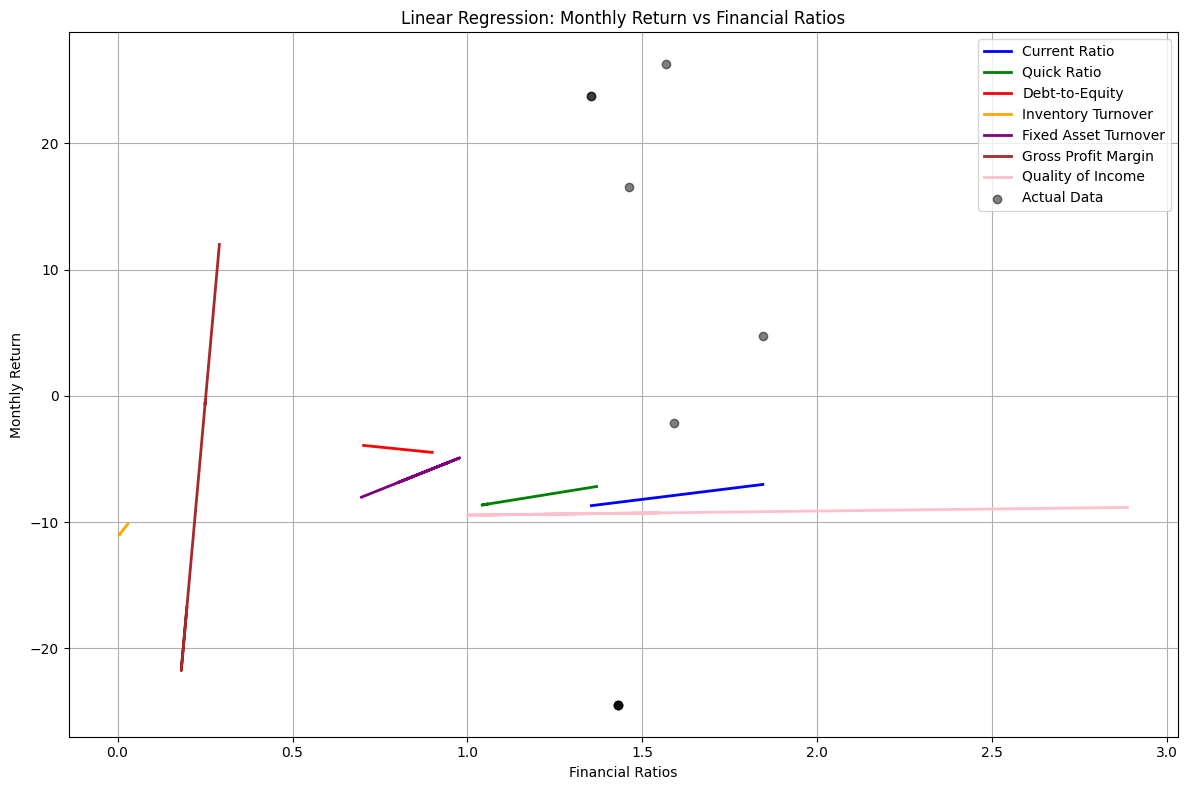

Current Ratio - R² score: -0.1298, Mean Absolute Error: 20.5622
Quick Ratio - R² score: -0.1407, Mean Absolute Error: 20.6757
Debt-to-Equity - R² score: -0.0316, Mean Absolute Error: 19.8818
Inventory Turnover - R² score: -0.2190, Mean Absolute Error: 21.1469
Fixed Asset Turnover - R² score: -0.0136, Mean Absolute Error: 19.7694
Gross Profit Margin - R² score: -0.2547, Mean Absolute Error: 22.1244
Quality of Income - R² score: -0.1702, Mean Absolute Error: 20.8745


In [92]:
# Step 1: Merge the dataframes on 'Date'
merged_df = pd.merge(monthly_returns_df, train_fin_df, left_on='Date', right_on='Date', how='inner')

# Step 2: Prepare the data
# Drop any rows with missing values
merged_df.dropna(inplace=True)

# Define the target variable (Monthly Return)
y = merged_df['Monthly Return']

# Step 3: Split the data manually
# Use the first 10 rows as the test set and the last 20 rows as the training set
X_train = merged_df[['Current Ratio', 'Quick Ratio', 'Debt-to-Equity', 'Inventory Turnover', 
                     'Fixed Asset Turnover', 'Gross Profit Margin', 'Quality of Income']].iloc[10:]
X_test = merged_df[['Current Ratio', 'Quick Ratio', 'Debt-to-Equity', 'Inventory Turnover', 
                    'Fixed Asset Turnover', 'Gross Profit Margin', 'Quality of Income']].iloc[:10]
y_train = y.iloc[10:]
y_test = y.iloc[:10]

# Step 4: Build and train a separate model for each financial ratio
plt.figure(figsize=(12, 8))

# List of financial ratios
ratios = ['Current Ratio', 'Quick Ratio', 'Debt-to-Equity', 'Inventory Turnover', 
          'Fixed Asset Turnover', 'Gross Profit Margin', 'Quality of Income']

# Define unique colors for each variable
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray']

# Loop through each financial ratio, fit the model, and plot
for i, ratio in enumerate(ratios):
    # Select one feature at a time for the linear regression
    X_train_single = X_train[[ratio]]
    X_test_single = X_test[[ratio]]

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train_single, y_train)

    # Make predictions
    y_pred = model.predict(X_test_single)

    # Plot the regression line for each ratio on the same graph
    plt.plot(X_test_single, y_pred, label=f'{ratio}', color=colors[i], linewidth=2)  # Regression line

# Plot actual data points (Monthly Return vs. X_test)
# We are using only the first column of X_test for simplicity since we are plotting against individual features
plt.scatter(X_test[ratios[0]], y_test, color='black', label='Actual Data', alpha=0.5)

# Add title and labels
plt.title('Linear Regression: Monthly Return vs Financial Ratios')
plt.xlabel('Financial Ratios')
plt.ylabel('Monthly Return')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Print model performance metrics for each model
for i, ratio in enumerate(ratios):
    # Select one feature at a time for the linear regression
    X_train_single = X_train[[ratio]]
    X_test_single = X_test[[ratio]]
    
    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X_train_single, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_single)
    
    # Calculate R² score and Mean Absolute Error (MAE)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'{ratio} - R² score: {r2:.4f}, Mean Absolute Error: {mae:.4f}')
